In [1]:
import os
import numpy as np
import pandas as pd
from skimage.io import imread
from time import time
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import AxesGrid
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import  cross_val_score
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV, KFold, cross_validate
from sklearn.linear_model import Perceptron
from sklearn.decomposition import PCA
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, Dropout, UpSampling3D, concatenate
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, concatenate, UpSampling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import LearningRateScheduler, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random 
import nibabel as nib
import pickle
import glob
from tqdm import tqdm

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


# **I - Segmentation**

## Model architecture

### UNet

In [2]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, UpSampling2D, Concatenate, BatchNormalization, Activation, Add, Conv2DTranspose
from tensorflow.keras.models import Model

def unet_multiclass(input_shape=(128, 128, 1), n_classes=4):
    def conv_block(input, filters, kernel_size=3, strides=1, padding='same'):
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(input)
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        x = Conv2D(filters, kernel_size, strides=strides, padding=padding)(x)
        x = BatchNormalization()(x)

        # Add residual connection
        input_res = Conv2D(filters, kernel_size=1, strides=strides, padding=padding)(input)
        input_res = BatchNormalization()(input_res)
        x = Add()([x, input_res])

        x = Activation('relu')(x)
        return x


    inputs = Input(shape=input_shape)

    # Contracting path
    conv1 = conv_block(inputs, 32)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = conv_block(pool1, 64)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = conv_block(pool2, 128)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = conv_block(pool3, 256)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    # Bottom
    conv5 = conv_block(pool4, 512)
    drop5 = Dropout(0.5)(conv5)

    # Expanding path
    up6 = Conv2DTranspose(256, kernel_size=2, strides=2, padding='same')(drop5)
    res6 = Conv2D(256, kernel_size=1, padding='same')(conv4)
    up6 = Concatenate()([up6, res6])
    conv6 = conv_block(up6, 256)

    up7 = Conv2DTranspose(128, kernel_size=2, strides=2, padding='same')(conv6)
    res7 = Conv2D(128, kernel_size=1, padding='same')(conv3)
    up7 = Concatenate()([up7, res7])
    conv7 = conv_block(up7, 128)

    up8 = Conv2DTranspose(64, kernel_size=2, strides=2, padding='same')(conv7)
    res8 = Conv2D(64, kernel_size=1, padding='same')(conv2)
    up8 = Concatenate()([up8, res8])
    conv8 = conv_block(up8, 64)

    up9 = Conv2DTranspose(32, kernel_size=2, strides=2, padding='same')(conv8)
    res9 = Conv2D(32, kernel_size=1, padding='same')(conv1)
    up9 = Concatenate()([up9, res9])
    conv9 = conv_block(up9, 32)
    
    outputs = Conv2D(n_classes, kernel_size=1, activation='softmax')(conv9)

    model = Model(inputs, outputs)
    return model

### Segnet

In [3]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras import backend as K
from keras.optimizers import Adam, SGD
import tensorflow as tf

def segnet():

    # Encoding layer
    img_input = Input(shape= (128, 128, 1))
    x = Conv2D(64, (3, 3), padding='same', name='conv1',strides= (1,1))(img_input)
    x = BatchNormalization(name='bn1')(x)
    x = Activation('relu')(x)
    x = Conv2D(64, (3, 3), padding='same', name='conv2')(x)
    x = BatchNormalization(name='bn2')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(128, (3, 3), padding='same', name='conv3')(x)
    x = BatchNormalization(name='bn3')(x)
    x = Activation('relu')(x)
    x = Conv2D(128, (3, 3), padding='same', name='conv4')(x)
    x = BatchNormalization(name='bn4')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(256, (3, 3), padding='same', name='conv5')(x)
    x = BatchNormalization(name='bn5')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv6')(x)
    x = BatchNormalization(name='bn6')(x)
    x = Activation('relu')(x)
    x = Conv2D(256, (3, 3), padding='same', name='conv7')(x)
    x = BatchNormalization(name='bn7')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Conv2D(512, (3, 3), padding='same', name='conv8')(x)
    x = BatchNormalization(name='bn8')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv9')(x)
    x = BatchNormalization(name='bn9')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv10')(x)
    x = BatchNormalization(name='bn10')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)
    
    x = Conv2D(512, (3, 3), padding='same', name='conv11')(x)
    x = BatchNormalization(name='bn11')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv12')(x)
    x = BatchNormalization(name='bn12')(x)
    x = Activation('relu')(x)
    x = Conv2D(512, (3, 3), padding='same', name='conv13')(x)
    x = BatchNormalization(name='bn13')(x)
    x = Activation('relu')(x)
    x = MaxPooling2D()(x)

    x = Dense(1024, activation = 'relu', name='fc1')(x)
    x = Dense(1024, activation = 'relu', name='fc2')(x)
    # Decoding Layer 
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv1')(x)
    x = BatchNormalization(name='bn14')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv2')(x)
    x = BatchNormalization(name='bn15')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv3')(x)
    x = BatchNormalization(name='bn16')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv4')(x)
    x = BatchNormalization(name='bn17')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(512, (3, 3), padding='same', name='deconv5')(x)
    x = BatchNormalization(name='bn18')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv6')(x)
    x = BatchNormalization(name='bn19')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv7')(x)
    x = BatchNormalization(name='bn20')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(256, (3, 3), padding='same', name='deconv8')(x)
    x = BatchNormalization(name='bn21')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv9')(x)
    x = BatchNormalization(name='bn22')(x)
    x = Activation('relu')(x)

    x = UpSampling2D()(x)
    x = Conv2DTranspose(128, (3, 3), padding='same', name='deconv10')(x)
    x = BatchNormalization(name='bn23')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv11')(x)
    x = BatchNormalization(name='bn24')(x)
    x = Activation('relu')(x)
    
    x = UpSampling2D()(x)
    x = Conv2DTranspose(64, (3, 3), padding='same', name='deconv12')(x)
    x = BatchNormalization(name='bn25')(x)
    x = Activation('relu')(x)
    x = Conv2DTranspose(4, (1, 1), padding='same', name='deconv13')(x)
    x = BatchNormalization(name='bn26')(x)
    x = Activation('softmax')(x)
    pred = Reshape((128,128,4))(x)
    
    model = Model(inputs=img_input, outputs=pred)
    
    return model

### SAM Segnet

In [4]:
from keras.layers import Add

def SAM_block(input_layer, nb_filters, kernel_size=(3, 3), padding='same', strides=(1, 1)):
    x = Conv2D(nb_filters, kernel_size, padding=padding, strides=strides)(input_layer)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x1 = Conv2D(nb_filters, kernel_size, padding=padding, strides=strides)(x)
    x1 = BatchNormalization()(x1)

    x2 = Conv2D(nb_filters, kernel_size, padding=padding, strides=strides)(x)
    x2 = BatchNormalization()(x2)
    x2 = Activation('relu')(x2)
    x2 = Conv2D(nb_filters, kernel_size, padding=padding, strides=strides)(x2)
    x2 = BatchNormalization()(x2)

    added = Add()([x1, x2])
    added = Activation('relu')(added)

    return added

def segnet_sam():
    img_input = Input(shape=(128, 128, 1))

    # Encoding layer (use SAM_block instead of Conv2D)
    x = SAM_block(img_input, 64)
    x = MaxPooling2D()(x)
    x = SAM_block(x, 128)
    x = MaxPooling2D()(x)
    x = SAM_block(x, 256)
    x = MaxPooling2D()(x)
    x = SAM_block(x, 512)
    x = MaxPooling2D()(x)

    # Decoding layer (use SAM_block instead of Conv2DTranspose)
    x = UpSampling2D()(x)
    x = SAM_block(x, 512)
    x = UpSampling2D()(x)
    x = SAM_block(x, 256)
    x = UpSampling2D()(x)
    x = SAM_block(x, 128)
    x = UpSampling2D()(x)
    x = SAM_block(x, 64)

    # Output layer
    x = Conv2D(4, (1, 1), padding='same')(x)
    x = BatchNormalization()(x)
    x = Activation('softmax')(x)
    pred = Reshape((128, 128, 4))(x)

    model = Model(inputs=img_input, outputs=pred)

    return model


## Utils

In [5]:
def normalize_image(image):
    mean = np.mean(image)
    std = np.std(image)
    image_normalized = (image - mean) / std
    return image_normalized

In [6]:
import cv2

def load_data(subject_folder, mritype, img_shape=(128, 128), channel=0, channels=10):
    if mritype == "ED":
        image = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ED.nii')).get_fdata()
        seg = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ED_seg.nii')).get_fdata()

    elif mritype == "ES":
        image = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ES.nii')).get_fdata()
        seg = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ES_seg.nii')).get_fdata()

    if image.shape[-1] < channels:
        image = np.pad(image, [(0, 0)] * (image.ndim - 1) + [(0, channels - image.shape[-1])], mode='constant')
    if seg.shape[-1] < channels:
        seg = np.pad(seg, [(0, 0)] * (seg.ndim - 1) + [(0, channels - seg.shape[-1])], mode='constant')

    image = cv2.resize(image, img_shape, interpolation=cv2.INTER_CUBIC)
    seg = cv2.resize(seg, img_shape, interpolation=cv2.INTER_CUBIC)

    image = normalize_image(image)

    return image[:, :, channel], seg[:, :, channel]

# **Loading the train data**

In [7]:
train_folders = ["/kaggle/input/challenge/Train/"+('%03d' % x) for x in range(1,101)]

from sklearn.model_selection import train_test_split

# Load all data into memory
data = []
mri_types = ["ED", "ES"]
channels = list(range(10))
for folder in tqdm(train_folders):
    for mtype in mri_types:
        for c in channels:
            data.append(load_data(folder, mtype, channel=c))

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(
    np.array([d[0] for d in data]),  # Volumes
    np.array([d[1] for d in data]),  # Segmentations
    test_size=0.2)

# Reshape X_train to have a rank of 4
X_train = X_train.reshape(X_train.shape + (1,))

100%|██████████| 100/100 [00:34<00:00,  2.87it/s]


# **Model training**

In [8]:
import tensorflow.keras.backend as K

# Convert y_train and y_val to one-hot encoded format
y_train_onehot = tf.keras.utils.to_categorical(y_train, num_classes=4)
y_val_onehot = tf.keras.utils.to_categorical(y_val, num_classes=4)

def dice_coef(y_true, y_pred, smooth=1):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2 * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

def combined_loss(y_true, y_pred, alpha=0.5):
    ce_loss = tf.keras.losses.categorical_crossentropy(y_true, y_pred)
    dice_loss = 1 - dice_coef(y_true, y_pred)
    combined = alpha * ce_loss + (1 - alpha) * dice_loss
    return combined

# Set up early stopping and model checkpoints
early_stopping = EarlyStopping(monitor='val_loss', patience=10)
model_checkpoint = ModelCheckpoint('best_model_segnet.h5', monitor='val_loss', save_best_only=True)
# Learning rate scheduler
def scheduler(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return lr * 0.95

lr_scheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

### UNet

In [9]:
#model = unet_multiclass()
#model.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999), loss=combined_loss, metrics=[dice_coef])
#model.fit(X_train, y_train_onehot, epochs= 100, batch_size= 8, validation_data= (X_val, y_val_onehot), verbose=1,callbacks = [early_stopping, lr_scheduler,model_checkpoint] )

### SegNet

In [10]:
#model = segnet()
#model.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999), loss=combined_loss, metrics=[dice_coef])
#model.fit(X_train, y_train_onehot, epochs= 100, batch_size= 8, validation_data= (X_val, y_val_onehot), verbose=1,callbacks = [early_stopping, lr_scheduler,model_checkpoint] )

### SegNet SAM

In [11]:
model = segnet_sam()
model.compile(optimizer=Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999), loss=combined_loss, metrics=[dice_coef])
model.fit(X_train, y_train_onehot, epochs=50, batch_size=8, validation_data=(X_val, y_val_onehot), verbose=1, callbacks=[early_stopping, lr_scheduler, model_checkpoint])

Epoch 1/50
200/200 [==============================] - 34s 126ms/step - loss: 0.4515 - dice_coef: 0.6530 - val_loss: 1.7040 - val_dice_coef: 0.6995 - lr: 0.0100
Epoch 2/50
200/200 [==============================] - 25s 127ms/step - loss: 0.1127 - dice_coef: 0.9121 - val_loss: 0.1832 - val_dice_coef: 0.9137 - lr: 0.0100
Epoch 3/50
200/200 [==============================] - 25s 126ms/step - loss: 0.0692 - dice_coef: 0.9482 - val_loss: 0.0903 - val_dice_coef: 0.9536 - lr: 0.0100
Epoch 4/50
200/200 [==============================] - 24s 122ms/step - loss: 0.0515 - dice_coef: 0.9624 - val_loss: 0.0418 - val_dice_coef: 0.9712 - lr: 0.0100
Epoch 5/50
200/200 [==============================] - 23s 116ms/step - loss: 0.0431 - dice_coef: 0.9692 - val_loss: 0.0560 - val_dice_coef: 0.9668 - lr: 0.0100
Epoch 6/50
200/200 [==============================] - 24s 122ms/step - loss: 0.0370 - dice_coef: 0.9738 - val_loss: 0.0320 - val_dice_coef: 0.9789 - lr: 0.0100
Epoch 7/50
200/200 [====================

## Visualization

In [12]:
def superpose_seg(image, left_ventricle_segmentation):

    # Scale the input image to a range of 0-255
    normalized_image = cv2.normalize(image, None, 0, 255, cv2.NORM_MINMAX)

    # Convert the scaled image to an 8-bit unsigned integer image
    image = cv2.convertScaleAbs(normalized_image)

    # Convert the grayscale image to a 3-channel color image
    img_color = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Create color maps for each class
    class1_color = [0, 0, 255] # blue
    class2_color = [0, 255, 0] # green
    class3_color = [255, 0, 0] # red

    # Create a blank image with the same size and type as the original image
    result = np.zeros_like(img_color)

    # Apply color maps to the corresponding classes in the segmentation mask
    result[left_ventricle_segmentation[:,:,1] > 0.01] = class1_color
    result[left_ventricle_segmentation[:,:,2] > 0.01] = class2_color
    result[left_ventricle_segmentation[:,:,3] > 0.01] = class3_color

    # Overlay the colored mask on the original image
    alpha = 0.5
    overlay = cv2.addWeighted(img_color, 1-alpha, result, alpha, 0)
    
    return overlay

In [13]:
image,seg = load_data("/kaggle/input/challenge/Train/070", "ED", channel=0)
input_image = image[np.newaxis, :, :, np.newaxis]
predicted_segmentation = model.predict(input_image)
left_ventricle_segmentation = predicted_segmentation[0, :, :, :]
seg = tf.keras.utils.to_categorical(seg, num_classes=4)

1/1 [==============================] - 1s 805ms/step


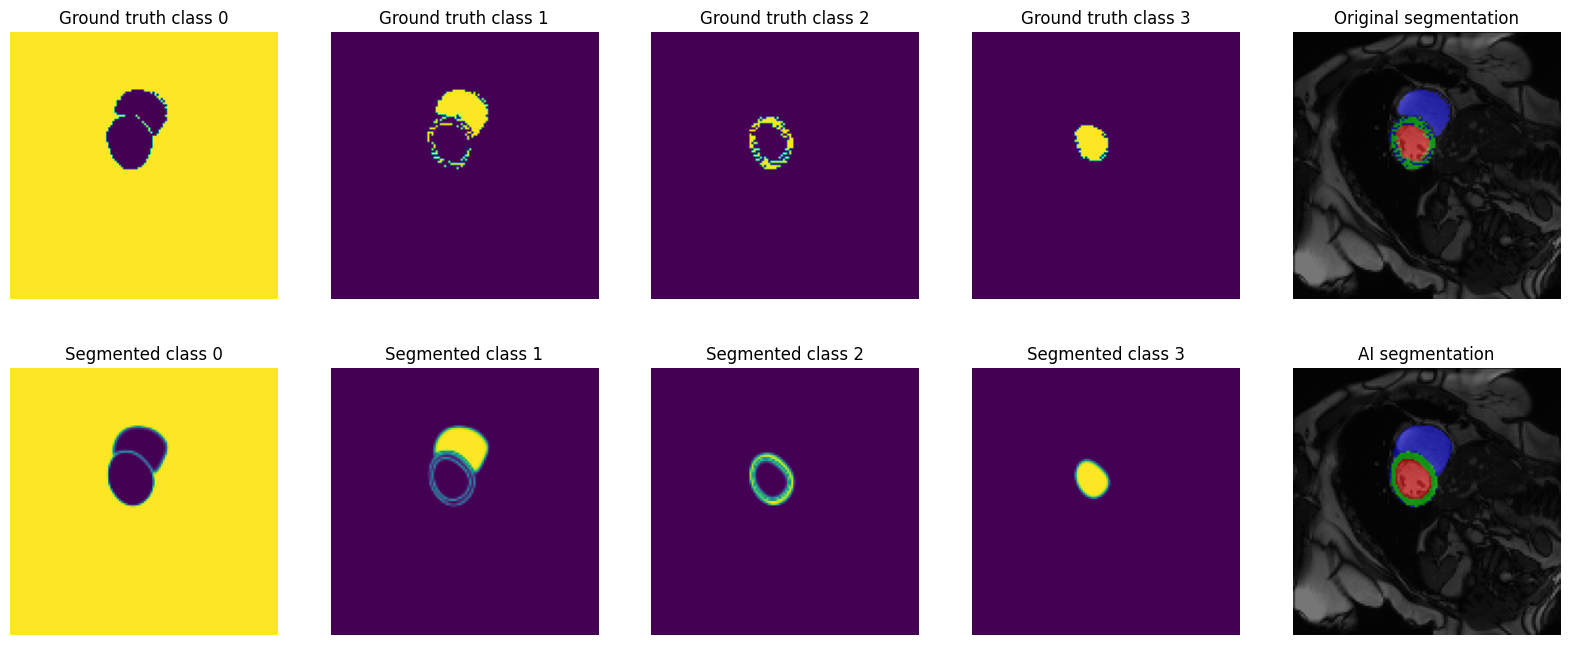

In [14]:
fig, axes = plt.subplots(2, 5, figsize=(20, 8))

# Plot y_train_onehot images in the first row
for i in range(4):
    axes[0][i].imshow(seg[:, :, i])
    axes[0][i].set_title(f"Ground truth class {i}")
    axes[0][i].axis("off")

# Plot left_ventricle_segmentation images in the second row
for i in range(4):
    axes[1][i].imshow(left_ventricle_segmentation[:, :, i])
    axes[1][i].set_title(f"Segmented class {i}")
    axes[1][i].axis("off")

# Plot the original image in the center column of each row
axes[0][4].imshow(superpose_seg(image, seg), cmap='gray')
axes[0][4].set_title('Original segmentation')
axes[0][4].axis('off')

axes[1][4].imshow(superpose_seg(image, left_ventricle_segmentation), cmap='gray')
axes[1][4].set_title('AI segmentation')
axes[1][4].axis('off')

plt.show()

1/1 [==============================] - 0s 22ms/step


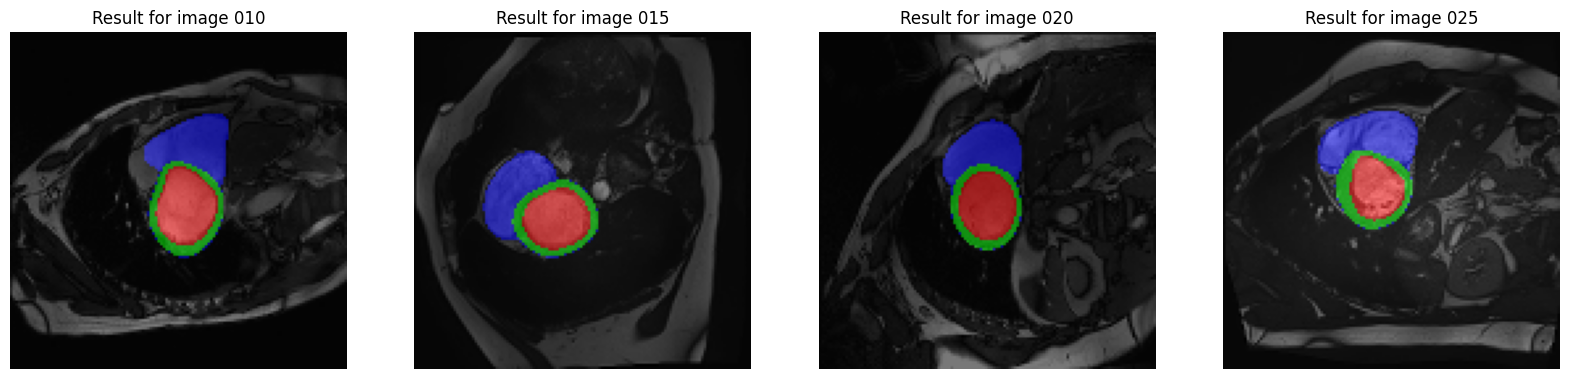

In [15]:
fig, axes = plt.subplots(1, 4, figsize=(20, 5))

i = 0

images = ["010", "015", "020", "025"]

for im in images:
    
    im_path = "/kaggle/input/challenge/Train/" + im
    
    image,seg = load_data(im_path, "ED", channel=0)
    input_image = image[np.newaxis, :, :, np.newaxis]
    predicted_segmentation = model.predict(input_image)
    left_ventricle_segmentation = predicted_segmentation[0, :, :, :]
    
    axes[i].imshow(superpose_seg(image, left_ventricle_segmentation), cmap='gray')
    axes[i].set_title(f"Result for image {im}")
    axes[i].axis("off")
    
    i += 1

# Predict the segmentation masks for the test set

In [16]:
import cv2

def load_data(subject_folder, mritype, img_shape=(128, 128)):
    if mritype == "ED":
        image = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ED.nii')).get_fdata()
        seg = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ED_seg.nii')).get_fdata()

    elif mritype == "ES":
        image = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ES.nii')).get_fdata()
        seg = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ES_seg.nii')).get_fdata()

    image = cv2.resize(image, img_shape, interpolation=cv2.INTER_CUBIC)
    seg = cv2.resize(seg, img_shape, interpolation=cv2.INTER_CUBIC)

    image = normalize_image(image)
    
    num_channels = seg.shape[-1]

    return image, seg, num_channels 

In [17]:
def load_header(subject_folder, mritype, img_shape=(128, 128)):
    if mritype == "ED":
        head = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ED_seg.nii')).header

    elif mritype == "ES":
        head = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ES_seg.nii')).header

    return head

In [18]:
test_folders = ["/kaggle/input/challenge/Test/"+('%03d' % x) for x in range(101,151)]

# Load all data into memory
mri_types = ["ED", "ES"]
num = 100
output_folder = "/kaggle/working/predicted_test_seg/"

# Create the output folder if it does not exist
if not os.path.exists(output_folder):
    os.makedirs(output_folder)

for folder in tqdm(test_folders):
    num += 1
    patient_folder = os.path.join(output_folder, f"{num:03d}")
    
    # Create the patient folder if it does not exist
    if not os.path.exists(patient_folder):
        os.makedirs(patient_folder)
         
    for mtype in mri_types:
        image, seg, nc = load_data(folder, mtype)
        header = load_header(folder, mtype)
        file = []
        for c in range(nc):
            input_image = image[:, :, c]
            input_image = input_image[np.newaxis, :, :, np.newaxis]
            predicted_segmentation = model.predict(input_image)
            segmentation = predicted_segmentation[0, :, :, :]
            file.append(segmentation)

        files = np.array(file)
   
        filename = os.path.join(patient_folder, f"{num:03d}_{mtype}_seg.nii")
        img = nib.Nifti1Image(files, np.eye(4), header=header)
        
        nib.save(img, filename)

  0%|          | 0/50 [00:00<?, ?it/s]

1/1 [==============================] - 0s 21ms/step


  2%|▏         | 1/50 [00:01<01:07,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


  4%|▍         | 2/50 [00:03<01:26,  1.81s/it]

1/1 [==============================] - 0s 23ms/step


  6%|▌         | 3/50 [00:04<01:14,  1.59s/it]

1/1 [==============================] - 0s 22ms/step


  8%|▊         | 4/50 [00:05<01:03,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 10%|█         | 5/50 [00:09<01:33,  2.08s/it]

1/1 [==============================] - 0s 23ms/step


 12%|█▏        | 6/50 [00:10<01:19,  1.80s/it]

1/1 [==============================] - 0s 21ms/step


 14%|█▍        | 7/50 [00:12<01:22,  1.91s/it]

1/1 [==============================] - 0s 22ms/step


 16%|█▌        | 8/50 [00:14<01:14,  1.77s/it]

1/1 [==============================] - 0s 23ms/step


 18%|█▊        | 9/50 [00:16<01:15,  1.84s/it]

1/1 [==============================] - 0s 24ms/step


 20%|██        | 10/50 [00:18<01:19,  1.98s/it]

1/1 [==============================] - 0s 22ms/step


 22%|██▏       | 11/50 [00:19<01:09,  1.78s/it]

1/1 [==============================] - 0s 23ms/step


 24%|██▍       | 12/50 [00:20<01:01,  1.63s/it]

1/1 [==============================] - 0s 23ms/step


 26%|██▌       | 13/50 [00:22<00:55,  1.51s/it]

1/1 [==============================] - 0s 34ms/step


 28%|██▊       | 14/50 [00:23<00:55,  1.55s/it]

1/1 [==============================] - 0s 23ms/step


 30%|███       | 15/50 [00:24<00:49,  1.42s/it]

1/1 [==============================] - 0s 24ms/step


 32%|███▏      | 16/50 [00:27<00:57,  1.68s/it]

1/1 [==============================] - 0s 23ms/step


 34%|███▍      | 17/50 [00:28<00:53,  1.61s/it]

1/1 [==============================] - 0s 22ms/step


 36%|███▌      | 18/50 [00:30<00:50,  1.57s/it]

1/1 [==============================] - 0s 21ms/step


 38%|███▊      | 19/50 [00:31<00:45,  1.47s/it]

1/1 [==============================] - 0s 22ms/step


 40%|████      | 20/50 [00:32<00:40,  1.36s/it]

1/1 [==============================] - 0s 22ms/step


 42%|████▏     | 21/50 [00:33<00:37,  1.28s/it]

1/1 [==============================] - 0s 22ms/step


 44%|████▍     | 22/50 [00:34<00:36,  1.30s/it]

1/1 [==============================] - 0s 23ms/step


 46%|████▌     | 23/50 [00:36<00:35,  1.32s/it]

1/1 [==============================] - 0s 23ms/step


 48%|████▊     | 24/50 [00:37<00:33,  1.29s/it]

1/1 [==============================] - 0s 24ms/step


 50%|█████     | 25/50 [00:38<00:33,  1.32s/it]

1/1 [==============================] - 0s 24ms/step


 52%|█████▏    | 26/50 [00:40<00:32,  1.34s/it]

1/1 [==============================] - 0s 22ms/step


 54%|█████▍    | 27/50 [00:41<00:31,  1.38s/it]

1/1 [==============================] - 0s 23ms/step


 56%|█████▌    | 28/50 [00:42<00:28,  1.29s/it]

1/1 [==============================] - 0s 22ms/step


 58%|█████▊    | 29/50 [00:44<00:27,  1.31s/it]

1/1 [==============================] - 0s 22ms/step


 60%|██████    | 30/50 [00:45<00:26,  1.34s/it]

1/1 [==============================] - 0s 21ms/step


 62%|██████▏   | 31/50 [00:47<00:25,  1.35s/it]

1/1 [==============================] - 0s 23ms/step


 64%|██████▍   | 32/50 [00:49<00:31,  1.75s/it]

1/1 [==============================] - 0s 23ms/step


 66%|██████▌   | 33/50 [00:50<00:25,  1.47s/it]

1/1 [==============================] - 0s 24ms/step


 68%|██████▊   | 34/50 [00:52<00:23,  1.49s/it]

1/1 [==============================] - 0s 22ms/step


 70%|███████   | 35/50 [00:53<00:20,  1.38s/it]

1/1 [==============================] - 0s 36ms/step


 72%|███████▏  | 36/50 [00:54<00:20,  1.46s/it]

1/1 [==============================] - 0s 24ms/step


 74%|███████▍  | 37/50 [00:56<00:19,  1.48s/it]

1/1 [==============================] - 0s 23ms/step


 76%|███████▌  | 38/50 [00:57<00:18,  1.50s/it]

1/1 [==============================] - 0s 21ms/step


 78%|███████▊  | 39/50 [00:59<00:16,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 80%|████████  | 40/50 [01:01<00:17,  1.72s/it]

1/1 [==============================] - 0s 25ms/step


 82%|████████▏ | 41/50 [01:03<00:14,  1.64s/it]

1/1 [==============================] - 0s 22ms/step


 84%|████████▍ | 42/50 [01:04<00:12,  1.55s/it]

1/1 [==============================] - 0s 21ms/step


 86%|████████▌ | 43/50 [01:05<00:10,  1.48s/it]

1/1 [==============================] - 0s 22ms/step


 88%|████████▊ | 44/50 [01:06<00:08,  1.40s/it]

1/1 [==============================] - 0s 23ms/step


 90%|█████████ | 45/50 [01:09<00:08,  1.76s/it]

1/1 [==============================] - 0s 21ms/step


 92%|█████████▏| 46/50 [01:10<00:06,  1.62s/it]

1/1 [==============================] - 0s 23ms/step


 94%|█████████▍| 47/50 [01:11<00:04,  1.46s/it]

1/1 [==============================] - 0s 23ms/step


 96%|█████████▌| 48/50 [01:13<00:02,  1.41s/it]

1/1 [==============================] - 0s 22ms/step


 98%|█████████▊| 49/50 [01:14<00:01,  1.34s/it]

1/1 [==============================] - 0s 22ms/step


100%|██████████| 50/50 [01:15<00:00,  1.51s/it]


# **II- Feature extraction**

## Manually extracted features

In [38]:
def myocardial_thickness(mask_ED, mask_ES):
    end_diastole_lv_boundary = find_boundaries(mask_ED, mode='inner')
    end_systole_lv_boundary = find_boundaries(mask_ES, mode='inner')

    # Compute the centroids of the endocardial surfaces
    end_diastole_lv_centroid = ndimage.center_of_mass(end_diastole_lv_boundary)
    end_systole_lv_centroid = ndimage.center_of_mass(end_systole_lv_boundary)

    end_diastole_lv_distance = np.sqrt(np.sum((np.indices(mask_ED.shape) - np.array(end_diastole_lv_centroid)[:, np.newaxis, np.newaxis, np.newaxis]) ** 2,axis=0))
    end_systole_lv_distance = np.sqrt(np.sum((np.indices(mask_ES.shape) - np.array(end_systole_lv_centroid)[:, np.newaxis, np.newaxis, np.newaxis]) ** 2, axis=0))

    # Compute the myocardial thickness as the minimum distance between each voxel in the left ventricle segmentation
    # masks and the endocardial surfaces
    end_diastole_thickness = np.min(end_diastole_lv_distance * mask_ED, axis=(0, 1, 2)).mean()
    end_systole_thickness = np.min(end_systole_lv_distance * mask_ES, axis=(0, 1, 2)).mean()
    
    if state=="ED":
        myocardial_thickness = np.abs(end_diastole_thickness)
        return myocardial_thickness
    if state=="ES":
        myocardial_thickness = np.abs(end_systole_thickness)
        return myocardial_thickness

In [48]:
import cv2
import numpy as np
from skimage.measure import label, regionprops
from scipy.stats import kurtosis, skew
from keras.preprocessing.image import ImageDataGenerator
from skimage.measure import label, regionprops
from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
import SimpleITK as sitk

ImportError: cannot import name 'QhullError' from 'scipy.spatial' (/opt/conda/lib/python3.10/site-packages/scipy/spatial/__init__.py)

In [45]:
#body surface area (BSA) 
def calculate_bsa(weight_kg, height_cm):
    bsa = 0.007184 * (weight_kg ** 0.425) * (height_cm ** 0.725)
    return bsa

def calculate_circularity(area, perimeter):
    if perimeter == 0:
        return 0
    return 4 * np.pi * area / (perimeter ** 2)


def extract_features(image, image_seg, num_channels, body_surface_area):
    # Intensity-based features
    mean_intensity = np.mean(image)
    var_intensity = np.var(image)
    gradient_magnitude = np.mean(np.gradient(image))

    # Texture-based features (GLCM)
    glcm = graycomatrix(rgb2gray(image[..., 0:3]).astype(np.uint8), [1], [0, np.pi / 4, np.pi / 2, 3 * np.pi / 4], symmetric=True, normed=True)
    contrast = graycoprops(glcm, 'contrast')
    dissimilarity = graycoprops(glcm, 'dissimilarity')
    homogeneity = graycoprops(glcm, 'homogeneity')
    energy = graycoprops(glcm, 'energy')
    correlation = graycoprops(glcm, 'correlation')
    
    image_features = [
        mean_intensity,
        var_intensity,
        gradient_magnitude,
    ]
    
    total_rvc_features = []
    total_lvm_features = []
    total_lvc_features = []
    
    for channel in range(num_channels + 1):
        rvc_features = [0] * 8
        lvm_features = [0] * 11
        lvc_features = [0] * 8
        for seg_class in range(1, 4):
        
            seg_mask = image_seg[:, :, num_channels, seg_class]
            labeled = label(seg_mask)
            regions = regionprops(labeled)

            if not regions:  # If no regions found, skip
                continue

            # Common features
            circularities = [calculate_circularity(region.area, region.perimeter) for region in regions]
            circumferences = [region.perimeter for region in regions]
            volumes = [region.area for region in regions]

            if seg_class == 1:  # RVC
                if volumes:
                    rvc_features[0] = np.mean(circularities)
                    rvc_features[1] = np.max(circumferences)
                    rvc_features[2] = np.mean(circumferences)
                    rvc_features[3] = np.sum(volumes) / body_surface_area
                    rvc_features[4] = np.max(volumes)
                    rvc_features[5] = kurtosis(volumes)
                    rvc_features[6] = skew(volumes)
                    rvc_features[7] = np.std(volumes)
                    
                    
                    
            elif seg_class == 2:  # LVM
                thicknesses = [region.major_axis_length for region in regions]

                if volumes:
                    lvm_features[0] = np.max(thicknesses)
                    lvm_features[1] = np.mean(thicknesses)
                    lvm_features[2] = np.mean(circularities)
                    lvm_features[3] = np.max(circumferences)
                    lvm_features[4] = np.mean(circumferences)
                    lvm_features[5] = np.sum(volumes) / body_surface_area
                    lvm_features[6] = np.max(volumes)
                    lvm_features[7] = (np.max(volumes) - np.min(volumes)) / np.max(volumes)
                    lvm_features[8] = kurtosis(volumes)
                    lvm_features[9] = skew(volumes)
                    lvm_features[10] = np.std(volumes)
                    
                    
            elif seg_class == 3: # LVC
                if volumes:
                    lvc_features[0] = np.sum(volumes) / body_surface_area
                    lvc_features[1] = np.max(volumes)
                    lvc_features[2] = np.min(volumes)
                    lvc_features[3] = (np.max(volumes) - np.min(volumes)) / np.max(volumes) if np.max(volumes) != 0 else 0
                    lvc_features[4] = np.median(volumes)
                    lvc_features[5] = kurtosis(volumes)
                    lvc_features[6] = skew(volumes)
                    lvc_features[7] = np.std(volumes)
                    
        total_rvc_features.append(rvc_features)
        total_lvm_features.append(lvm_features)
        total_lvc_features.append(lvc_features)
        
    if len(total_rvc_features) > 0:
        instant_features_rvc = np.mean(total_rvc_features, axis=0)
    else:
        instant_features_rvc = np.zeros(8)  # Set default values if the array is empty

    if len(total_lvm_features) > 0:
        instant_features_lvm = np.mean(total_lvm_features, axis=0)
    else:
        instant_features_lvm = np.zeros(11)  # Set default values if the array is empty

    if len(total_lvc_features) > 0:
        instant_features_lvc = np.mean(total_lvc_features, axis=0)
    else:
        instant_features_lvc = np.zeros(8) 


    
    return image_features, instant_features_rvc, instant_features_lvm, instant_features_lvc

# Data augmentation

In [22]:
#data augmentation
def apply_seg_augmentation(seg_onehot, batch_size=32, seed=42):
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=False,
                                  fill_mode='nearest')
    
    data_gen.fit(seg_onehot, augment=True, seed=seed)
    
    return data_gen.flow(seg_onehot, batch_size=batch_size, seed=seed)



def apply_image_augmentation(seg_onehot, batch_size=32, seed=42):
    # Add a dummy channel dimension
    seg_onehot_expanded = np.expand_dims(seg_onehot, axis=-1)
    
    data_gen = ImageDataGenerator(rotation_range=10,
                                  width_shift_range=0.1,
                                  height_shift_range=0.1,
                                  horizontal_flip=False,
                                  fill_mode='nearest')
    
    data_gen.fit(seg_onehot_expanded, augment=True, seed=seed)
    
    # Remove the dummy channel dimension from the output
    def remove_dummy_dim(batch):
        return np.squeeze(batch, axis=-1)
    
    return (remove_dummy_dim(batch) for batch in data_gen.flow(seg_onehot_expanded, batch_size=batch_size, seed=seed))

def process_augmented_subject(folder, metadata, mtype, use_data_augmentation=True, num_augmented_samples=5):
    image, seg_onehot, num_channels = load_data(folder, mtype)
    weight = metadata['Weight'].values[0]
    height = metadata['Height'].values[0]
    bsa = calculate_bsa(weight, height)
    
    if use_data_augmentation:
        image_generator = apply_image_augmentation(image)
        seg_onehot_generator = apply_seg_augmentation(seg_onehot)
        augmented_features = []
        for i in range(num_augmented_samples):
            image_augmented = next(image_generator)
            seg_onehot_augmented = next(seg_onehot_generator)
            augmented_feature = extract_features(image_augmented, seg_onehot_augmented, num_channels, bsa)
            augmented_features.append(augmented_feature)

    return augmented_features

def process_subject(folder, metadata, mtype):
    image, seg_onehot, num_channels = load_data(folder, mtype)
    weight = metadata['Weight'].values[0]
    height = metadata['Height'].values[0]
    bsa = calculate_bsa(weight, height)
    features = extract_features(image, seg_onehot, num_channels, bsa)
    return features

def process_test_subject(im_folder, seg_folder, metadata, mtype):
    image, seg_onehot, num_channels = load_data(im_folder,seg_folder, mtype)
    weight = metadata['Weight'].values[0]
    height = metadata['Height'].values[0]
    bsa = calculate_bsa(weight, height)
    features = extract_features(image, seg_onehot, num_channels, bsa)
    return features

## Pyradiomics features

In [26]:
'''import SimpleITK as sitk
from radiomics import featureextractor

def normalize_image(image):
    mean = np.mean(image)
    std = np.std(image)
    image_normalized = (image - mean) / std
    return image_normalized

def extract_features(img_path, mask_path, features_names):

    # Read the image and mask using SimpleITK
    image = sitk.ReadImage(img_path)
    mask_image = sitk.ReadImage(mask_path)

    # Define new size
    new_size = [128, 128, 10]

    # Resample image
    resample = sitk.ResampleImageFilter()
    resample.SetInterpolator(sitk.sitkLinear)
    resample.SetOutputDirection(image.GetDirection())
    resample.SetOutputOrigin(image.GetOrigin())
    resample.SetOutputSpacing([sz*spc/nsz for nsz,sz,spc in zip(new_size, image.GetSize(), image.GetSpacing())])
    resample.SetSize(new_size)
    image = resample.Execute(image)

    # Resample mask
    resample.SetInterpolator(sitk.sitkNearestNeighbor)
    resample.SetOutputDirection(mask_image.GetDirection())
    resample.SetOutputOrigin(mask_image.GetOrigin())
    resample.SetOutputSpacing([sz*spc/nsz for nsz,sz,spc in zip(new_size, mask_image.GetSize(), mask_image.GetSpacing())])
    resample.SetSize(new_size)
    mask_image = resample.Execute(mask_image)
    
    image = normalize_image(image)
    
    # Create a PyRadiomics feature extractor object and set the parameters
    params = {'binWidth': 25}
    
    extractor = featureextractor.RadiomicsFeatureExtractor(**params)
    extractor.disableAllFeatures()

    myo_features = []
    rv_features = []
    lv_features = []

    extractor.enableFeaturesByName(shape=['SurfaceArea', 'MeshVolume', 'SurfaceVolumeRatio', 'VoxelVolume', 'Elongation', 'Flatness', 'Sphericity', 'MinorAxisLength', 'MajorAxisLength'],
                                   firstorder = ['Energy', 'Entropy', 'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Skewness'],
                                   glrlm = ['RunLengthNonUniformity', 'LongRunEmphasis', 'ShortRunEmphasis', 'GrayLevelNonUniformity'],
                                   glszm = ['LargeAreaEmphasis', 'SmallAreaEmphasis', 'ZonePercentage'],
                                   glcm = ['Autocorrelation', 'Contrast'])
    
    # MYO Class

    # Extract the features for the current class
    features = extractor.execute(image, mask_image, label=1)

    for f in features_names:
        myo_features.append(features[f])

    # RV Class

    extractor = featureextractor.RadiomicsFeatureExtractor(**params)
    extractor.disableAllFeatures()
    
    # Extract the features for the current class
    extractor.enableFeaturesByName(shape=['SurfaceArea', 'MeshVolume', 'SurfaceVolumeRatio', 'VoxelVolume', 'Elongation', 'Flatness', 'Sphericity', 'MinorAxisLength', 'MajorAxisLength'],
                                   firstorder = ['Energy', 'Entropy', 'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Skewness'],
                                   glrlm = ['RunLengthNonUniformity', 'LongRunEmphasis', 'ShortRunEmphasis', 'GrayLevelNonUniformity'],
                                   glszm = ['LargeAreaEmphasis', 'SmallAreaEmphasis', 'ZonePercentage'],
                                   glcm = ['Autocorrelation', 'Contrast'])

    features = extractor.execute(image, mask_image, label=2)

    for f in features_names:
        rv_features.append(features[f])
      
    # LV Class
    extractor = featureextractor.RadiomicsFeatureExtractor(**params)
    extractor.disableAllFeatures()
    # Extract the features for the current class
    extractor.enableFeaturesByName(shape=['SurfaceArea', 'MeshVolume', 'SurfaceVolumeRatio', 'VoxelVolume', 'Elongation', 'Flatness', 'Sphericity', 'MinorAxisLength', 'MajorAxisLength'],
                                   firstorder = ['Energy', 'Entropy', 'Kurtosis', 'Maximum', 'MeanAbsoluteDeviation', 'Mean', 'Median', 'Minimum', 'Skewness'],
                                   glrlm = ['RunLengthNonUniformity', 'LongRunEmphasis', 'ShortRunEmphasis', 'GrayLevelNonUniformity'],
                                   glszm = ['LargeAreaEmphasis', 'SmallAreaEmphasis', 'ZonePercentage'],
                                   glcm = ['Autocorrelation', 'Contrast'])
    features = extractor.execute(image, mask_image, label=3)

    for f in features_names:
        lv_features.append(features[f])

    return myo_features, rv_features, lv_features'''

"import SimpleITK as sitk\nfrom radiomics import featureextractor\n\ndef normalize_image(image):\n    mean = np.mean(image)\n    std = np.std(image)\n    image_normalized = (image - mean) / std\n    return image_normalized\n\ndef extract_features(img_path, mask_path, features_names):\n\n    # Read the image and mask using SimpleITK\n    image = sitk.ReadImage(img_path)\n    mask_image = sitk.ReadImage(mask_path)\n\n    # Define new size\n    new_size = [128, 128, 10]\n\n    # Resample image\n    resample = sitk.ResampleImageFilter()\n    resample.SetInterpolator(sitk.sitkLinear)\n    resample.SetOutputDirection(image.GetDirection())\n    resample.SetOutputOrigin(image.GetOrigin())\n    resample.SetOutputSpacing([sz*spc/nsz for nsz,sz,spc in zip(new_size, image.GetSize(), image.GetSpacing())])\n    resample.SetSize(new_size)\n    image = resample.Execute(image)\n\n    # Resample mask\n    resample.SetInterpolator(sitk.sitkNearestNeighbor)\n    resample.SetOutputDirection(mask_image.GetD

In [25]:
'''from tqdm import tqdm
import joblib
from joblib import Parallel, delayed

train_folder = "/kaggle/input/challenge/Train/"
metadata_train = pd.read_csv("/kaggle/input/challenge/metaDataTrain.csv")

def process_subject(x, train_folder, metadata_train, features_names):
    
    
    folder = train_folder + ('%03d' % x)
    subject_id = int(os.path.basename(folder))
    metadata = metadata_train.loc[metadata_train['Id'] == subject_id]

    features_extended = []
    for mtype in ["ED", "ES"]:
        im_path = train_folder + ('%03d' % x) + '/' + ('%03d' % x) + '_' + mtype + '.nii'
        mask_path = train_folder + ('%03d' % x) + '/' + ('%03d' % x) + '_' + mtype + '_seg.nii'

        features = extract_features(im_path, mask_path, features_names)
        features_extended.extend(features)

    weight = metadata['Weight'].values[0]
    height = metadata['Height'].values[0]
    bsa = calculate_bsa(weight, height)

    features_extended.extend([bsa, weight, height])
    train_label = metadata['Category'].values[0]

    return features_extended + [train_label]

features_names = ["original_shape_VoxelVolume", "original_shape_SurfaceVolumeRatio", "original_shape_SurfaceArea", "original_shape_Elongation", "original_shape_Flatness", "original_shape_Sphericity",
                 "original_shape_MinorAxisLength", "original_shape_MajorAxisLength" ,"original_firstorder_Energy", "original_firstorder_Entropy", "original_firstorder_Kurtosis",
                 "original_firstorder_Maximum", "original_firstorder_MeanAbsoluteDeviation", "original_firstorder_Mean", "original_firstorder_Median", "original_firstorder_Minimum",
                 "original_glrlm_RunLengthNonUniformity", "original_glszm_LargeAreaEmphasis", "original_glszm_SmallAreaEmphasis", "original_glszm_ZonePercentage",
                 "original_firstorder_Skewness", "original_glcm_Autocorrelation", "original_glcm_Contrast", "original_glrlm_LongRunEmphasis", "original_glrlm_ShortRunEmphasis", "original_glrlm_GrayLevelNonUniformity"]

num_cores = joblib.cpu_count()
results = Parallel(n_jobs=num_cores)(
             delayed(process_subject)(x, train_folder, metadata_train, features_names) for x in tqdm(range(1,101)))'''

'from tqdm import tqdm\nimport joblib\nfrom joblib import Parallel, delayed\n\ntrain_folder = "/kaggle/input/challenge/Train/"\nmetadata_train = pd.read_csv("/kaggle/input/challenge/metaDataTrain.csv")\n\ndef process_subject(x, train_folder, metadata_train, features_names):\n    \n    \n    folder = train_folder + (\'%03d\' % x)\n    subject_id = int(os.path.basename(folder))\n    metadata = metadata_train.loc[metadata_train[\'Id\'] == subject_id]\n\n    features_extended = []\n    for mtype in ["ED", "ES"]:\n        im_path = train_folder + (\'%03d\' % x) + \'/\' + (\'%03d\' % x) + \'_\' + mtype + \'.nii\'\n        mask_path = train_folder + (\'%03d\' % x) + \'/\' + (\'%03d\' % x) + \'_\' + mtype + \'_seg.nii\'\n\n        features = extract_features(im_path, mask_path, features_names)\n        features_extended.extend(features)\n\n    weight = metadata[\'Weight\'].values[0]\n    height = metadata[\'Height\'].values[0]\n    bsa = calculate_bsa(weight, height)\n\n    features_extended.e

# Get the train features

In [28]:
def load_data(subject_folder, mritype, img_shape=(128, 128)):
    if mritype == "ED":
        image = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ED.nii')).get_fdata()
        seg = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ED_seg.nii')).get_fdata()

    elif mritype == "ES":
        image = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ES.nii')).get_fdata()
        seg = nib.load(os.path.join(subject_folder, f'{os.path.basename(subject_folder)}_ES_seg.nii')).get_fdata()

    

    image = cv2.resize(image, img_shape, interpolation=cv2.INTER_CUBIC)
    seg = cv2.resize(seg, img_shape, interpolation=cv2.INTER_CUBIC)

    seg_onehot = tf.keras.utils.to_categorical(seg, num_classes=4)
    seg_onehot = np.transpose(seg_onehot, (0, 1, 2, 3))
    
    # Get the number of channels of the image
    num_channels = seg_onehot.shape[-1]
    
    return image, seg_onehot, num_channels


In [29]:
metadata_train = pd.read_csv("/kaggle/input/challenge/metaDataTrain.csv")

# With data augmentation

In [30]:
train_data = []
train_folders = ["/kaggle/input/challenge/Train/"+('%03d' % x) for x in range(1,101)]

# Calculate BMI and add it to the metadata_train dataframe
metadata_train['BMI'] = metadata_train['Weight'] / ((metadata_train['Height'] / 100) ** 2)

feature_names = ["ED_image_features","ED_RVC_features", "ED_LVM_features", "ED_LVC_features","ES_image_features", "ES_RVC_features", "ES_LVM_features", "ES_LVC_features"]

for folder in tqdm(train_folders):
    subject_id = int(os.path.basename(folder))
    metadata = metadata_train.loc[metadata_train['Id'] == subject_id]

    features_combined = []
    for mtype in ["ED", "ES"]:
        features = process_subject(folder, metadata, mtype)
        features_combined.extend(features)

    weight = metadata['Weight'].values[0]
    height = metadata['Height'].values[0]
    bsa = calculate_bsa(weight, height)

    features_combined.extend([bsa, weight, height, metadata['BMI'].values[0]])
    train_label = metadata['Category'].values[0]

    train_data.append(features_combined + [train_label])

    # Process augmented data
    num_augmented_samples = 5
    for _ in range(num_augmented_samples):
        augmented_features_combined = []
        for mtype in ["ED", "ES"]:
            augmented_features = process_augmented_subject(folder, metadata, mtype, use_data_augmentation=True, num_augmented_samples=5)
            augmented_features_combined.extend(augmented_features[0])
        
        augmented_features_combined.extend([bsa, weight, height, metadata['BMI'].values[0]])
        train_data.append(augmented_features_combined + [train_label])

# Add BSA, weight, height, and BMI to the feature names
feature_names.extend(['BSA', 'Weight', 'Height', 'BMI'])

# Convert the list to a DataFrame
train_data_df = pd.DataFrame(train_data, columns=feature_names + ['label'])

  0%|          | 0/100 [00:00<?, ?it/s]


NameError: name 'graycomatrix' is not defined

# Without data augmentation

In [ ]:
''''train_data = []
train_folders = ["/kaggle/input/challenge/Train/"+('%03d' % x) for x in range(1,101)]

# Calculate BMI and add it to the metadata_train dataframe
metadata_train['BMI'] = metadata_train['Weight'] / ((metadata_train['Height'] / 100) ** 2)

feature_names = ["ED_image_features","ED_RVC_features", "ED_LVM_features", "ED_LVC_features","ES_image_features", "ES_RVC_features", "ES_LVM_features", "ES_LVC_features"]

for folder in tqdm(train_folders):
    subject_id = int(os.path.basename(folder))
    metadata = metadata_train.loc[metadata_train['Id'] == subject_id]

    features_combined = []
    for mtype in ["ED", "ES"]:
        features = process_subject(folder, metadata, mtype)
        features_combined.extend(features)

    weight = metadata['Weight'].values[0]
    height = metadata['Height'].values[0]
    bsa = calculate_bsa(weight, height)

    features_combined.extend([bsa, weight, height, metadata['BMI'].values[0]])
    train_label = metadata['Category'].values[0]

    train_data.append(features_combined + [train_label])   
    
# Add BSA, weight, height, and BMI to the feature names
feature_names.extend(['BSA', 'Weight', 'Height', 'BMI'])

# Convert the list to a DataFrame
train_data_df = pd.DataFrame(train_data, columns=feature_names + ['label'])''''

# Get test features

In [ ]:
from skimage.filters import threshold_otsu

def load_data(im_folder, seg_folder, mritype, img_shape=(128, 128)):
    subject_basename = os.path.basename(seg_folder)

    if mritype == "ED":
        image = nib.load(os.path.join(im_folder, f'{subject_basename}_ED.nii')).get_fdata()
        seg_o = nib.load(os.path.join(im_folder, f'{subject_basename}_ED_seg.nii')).get_fdata()
        seg_p = nib.load(os.path.join(seg_folder, f'{subject_basename}_ED_seg.nii')).get_fdata()
        
    elif mritype == "ES":
        image = nib.load(os.path.join(im_folder, f'{subject_basename}_ES.nii')).get_fdata()
        seg_o = nib.load(os.path.join(im_folder, f'{subject_basename}_ES_seg.nii')).get_fdata()
        seg_p= nib.load(os.path.join(seg_folder, f'{subject_basename}_ES_seg.nii')).get_fdata()
    
    image = cv2.resize(image, img_shape, interpolation=cv2.INTER_CUBIC)
    seg_o = cv2.resize(seg_o, img_shape, interpolation=cv2.INTER_CUBIC)
    
    seg_o = tf.keras.utils.to_categorical(seg_o, num_classes=4)
                                             
    seg_p= np.transpose(seg_p, (1, 2, 0, 3))
    seg_o= np.transpose(seg_o, (0, 1, 2, 3))
    
    # Assuming seg_o and seg_p are numpy arrays
    seg_o = seg_o[:,:,:,0:3]  # Slicing seg_o to keep only classes 0 to 2
    seg_p = seg_p[:,:,:,3]    # Slicing seg_p to get class 3
   
    thresh = threshold_otsu(seg_p)
    seg_p = seg_p > thresh
    
    # Adding a new axis to seg_p
    seg_p = seg_p[:,:,:,np.newaxis]

    # Concatenating seg_o and seg_p along the last axis
    seg_concat = np.concatenate((seg_o, seg_p), axis=-1)
    
    #seg_p = np.where(seg_p > 0.2, sep_p, 0)  # Apply threshold
    
    # Get the number of channels of the image
    num_channels = seg_o.shape[-1]
    
    return image, seg_concat, num_channels


In [ ]:
metadata_test = pd.read_csv("/kaggle/input/challenge/metaDataTest.csv")

In [ ]:
# Define the test folder
test_seg_folders = ["/kaggle/working/predicted_test_seg/"+('%03d' % x) for x in range(101,151)]
test_folders = ["/kaggle/input/challenge/Test/"+('%03d' % x) for x in range(101,151)]

# Calculate BMI and add it to the metadata_test dataframe
metadata_test['BMI'] = metadata_test['Weight'] / ((metadata_test['Height'] / 100) ** 2)

test_data = []

feature_names = ["ED_image_features","ED_RVC_features", "ED_LVM_features", "ED_LVC_features","ES_image_features", "ES_RVC_features", "ES_LVM_features", "ES_LVC_features"]

for test_folder, seg_folder in tqdm(zip(test_folders, test_seg_folders)):
    subject_id = int(os.path.basename(seg_folder))
    metadata = metadata_test.loc[metadata_test['Id'] == subject_id]

    features_combined = []
    for mtype in ["ED", "ES"]:
        features = process_test_subject(test_folder, seg_folder, metadata, mtype)
        features_combined.extend(features)

    weight = metadata['Weight'].values[0]
    height = metadata['Height'].values[0]
    bsa = calculate_bsa(weight, height)

    features_combined.extend([bsa, weight, height, metadata['BMI'].values[0]])

    test_data.append(features_combined)

# Add BSA, weight, height, and BMI to the feature names
feature_names.extend(['BSA', 'Weight', 'Height', 'BMI'])

# Convert the list to a DataFrame
test_data_df = pd.DataFrame(test_data, columns=feature_names)

# **III- Modelling**

# Expand the segmentation features and normalize all features

In [ ]:
from sklearn.preprocessing import StandardScaler

# Expand segmentation features
for col in train_data_df.columns:
    if 'features' in col:
        expanded = pd.DataFrame(train_data_df[col].tolist(), columns=[f'{col}_{i}' for i in range(len(train_data_df[col].iloc[0]))])
        train_data_df = pd.concat([train_data_df, expanded], axis=1)
        train_data_df.drop(col, axis=1, inplace=True)

# Get the names of all columns except the label column
feature_cols = [col for col in train_data_df.columns if col != 'label']

# Normalize all feature columns except the label column
scaler = StandardScaler()
train_data_df[feature_cols] = scaler.fit_transform(train_data_df[feature_cols])

In [ ]:
# Expand segmentation features
for col in test_data_df.columns:
    if 'features' in col:
        test_data_df = test_data_df.join(pd.DataFrame(test_data_df[col].tolist(), columns=[f'{col}_{i}' for i in range(len(test_data_df[col].iloc[0]))]))
        test_data_df.drop(col, axis=1, inplace=True)

# Normalize all features
scaler = StandardScaler()
test_data_df[test_data_df.columns] = scaler.fit_transform(test_data_df[test_data_df.columns])

In [ ]:
# Identify columns with all values equal to 0 in both DataFrames
zero_columns = [col for col in train_data_df.columns if (train_data_df[col] == 0).all() and (test_data_df[col] == 0).all() and col in test_data_df.columns]

# Drop the identified columns from both DataFrames
train_data_df = train_data_df.drop(columns=zero_columns)
test_data_df = test_data_df.drop(columns=zero_columns)

## Feature selection

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.decomposition import PCA

X = train_data_df.drop('label', axis=1).values
y = train_data_df['label'].values

# Random Forest feature selection
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)
importances = rf.feature_importances_

# Select the top k most important features
k = 50
top_k = np.argsort(importances)[::-1][:k]
X_selected = X_train[:, top_k]

# PCA
pca = PCA(n_components=50, random_state=42)
pca.fit(X)
X_pca = pca.transform(X)


# LightGBM Classifier

In [ ]:
''''import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import accuracy_score

# Create arrays for features and labels
X = train_data_df.drop('label', axis=1).values
y = train_data_df['label'].values

# Initialize k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set hyperparameters to tune
params = {
    'num_leaves': [15, 31, 63],
    'max_depth': [-1, 5, 10],
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 200, 300],
    'reg_alpha': [0, 0.1, 0.5],
    'reg_lambda': [0, 0.1, 0.5],
    'min_child_samples': [10, 20, 30]
}

# Initialize LightGBM model
lgbm = lgb.LGBMClassifier(objective='multiclass', num_class=5)

# Initialize GridSearchCV object
grid_search = GridSearchCV(lgbm, params, scoring='accuracy', cv=kfold)

# Fit GridSearchCV object to data
grid_search.fit(X, y)

# Print best hyperparameters and mean validation accuracy score
print('Best parameters:', grid_search.best_params_)
print('Mean validation accuracy score:', grid_search.best_score_)

# Initialize arrays for accuracy scores
train_acc_scores = []
valid_acc_scores = []

# Loop through each fold
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    print(f'Fold {i+1}')

    # Split data into train and validation sets
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # Initialize LightGBM model with best hyperparameters
    lgbm = lgb.LGBMClassifier(**grid_search.best_params_, objective='multiclass', num_class=5)

    # Train LightGBM model
    lgbm.fit(X_train, y_train)

    # Predict on train and validation sets
    y_train_pred = lgbm.predict(X_train)
    y_valid_pred = lgbm.predict(X_valid)

    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)

    train_acc_scores.append(train_acc)
    valid_acc_scores.append(valid_acc)

    print(f'Train accuracy: {train_acc:.4f}')
    print(f'Validation accuracy: {valid_acc:.4f}\n')

# Calculate mean accuracy scores
mean_train_acc = sum(train_acc_scores) / len(train_acc_scores)
mean_valid_acc = sum(valid_acc_scores) / len(valid_acc_scores)

print(f'Mean train accuracy: {mean_train_acc:.4f}')
print(f'Mean validation accuracy: {mean_valid_acc:.4f}')''''

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

# Create arrays for features and labels
X = train_data_df.drop('label', axis=1).values
y = train_data_df['label'].values

# Initialize k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Initialize arrays for accuracy scores
train_acc_scores = []
valid_acc_scores = []

# Set the parameters for the model
params = {
    'boosting_type': 'gbdt',
    'objective': 'multiclass', # Multiclass classification
    'num_class': 5, # Number of classes
    'metric': 'multi_logloss', # Evaluation metric
    'lambda_l1': 0.1, # L1 regularization
    'lambda_l2': 0.5, # L2 regularization
    'min_gain_to_split': 0.1, # Minimum gain to perform a split
    'max_depth': 5, # Maximum depth of a tree
    'min_child_samples': 20, # Minimum number of samples required to split a node
    'colsample_bytree': 0.8 # Fraction of features to be randomly sampled for each tree
}

# Loop through each fold
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    print(f'Fold {i+1}')

    # Split data into train and validation sets
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]
    
    # Create a LightGBM dataset
    train_data = lgb.Dataset(X_train, label=y_train)

    # Initialize LightGBM model with default hyperparameters
    model = lgb.train(params, train_data, num_boost_round=100)

    # Predict on train and validation sets
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)

    # Make predictions on the test set
    y_pred_train = model.predict(X_train)
    y_pred_val = model.predict(X_valid)

    # Convert predicted probabilities to class labels
    class_predictions_train = [int(p.argmax()) for p in y_pred_train]    
    class_predictions_val = [int(p.argmax()) for p in y_pred_val]

    # Evaluate the model performance
    train_acc = sum(class_predictions_train == y_train) / len(y_train)
    valid_acc = sum(class_predictions_val == y_valid) / len(y_valid)
    
    train_acc_scores.append(train_acc)
    valid_acc_scores.append(valid_acc)

    print(f'Train accuracy: {train_acc:.4f}')
    print(f'Validation accuracy: {valid_acc:.4f}\n')

# Calculate mean accuracy scores
mean_train_acc = sum(train_acc_scores) / len(train_acc_scores)
mean_valid_acc = sum(valid_acc_scores) / len(valid_acc_scores)

print(f'Mean train accuracy: {mean_train_acc:.4f}')
print(f'Mean validation accuracy: {mean_valid_acc:.4f}')


# Submission

In [ ]:
import csv

# Use the trained classifier to predict the categories for the test features
predicted_cat = model.predict(test_data_df)
predicted_categories = [int(p.argmax()) for p in predicted_cat]    



# Write the predicted categories to a new CSV file with the same format as the submission file

with open('submission_lgbm.csv', mode='w', newline='') as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow(['Id', 'Category'])
    for i, category in enumerate(predicted_categories):
        writer.writerow([i+101, category])

In [ ]:
submission = pd.read_csv('/kaggle/working/submission_lgbm.csv')
submission

# Random forrest classifier

In [ ]:
''''from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold, GridSearchCV

# Create arrays for features and labels
X = train_data_df.drop('label', axis=1).values
y = train_data_df['label'].values

# Initialize k-fold cross-validation
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# Set hyperparameters to tune
params = {
    'n_estimators': [400, 500, 1000],
    'max_depth': [None, 5, 10],
    'min_samples_split': [10, 15, 20],
    'min_samples_leaf': [4, 8, 12],
    'max_features': ['auto', 'sqrt', 'log2']
}

# Initialize Random Forest model
rfc = RandomForestClassifier(random_state=42)

# Initialize GridSearchCV object
grid_search = GridSearchCV(rfc, params, scoring='accuracy', cv=kfold)

# Fit GridSearchCV object to data
grid_search.fit(X, y)

# Print best hyperparameters and mean validation accuracy score
print('Best parameters:', grid_search.best_params_)
print('Mean validation accuracy score:', grid_search.best_score_)''''

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier


# Create arrays for features and labels
X = train_data_df.drop('label', axis=1).values
y = train_data_df['label'].values

# Initialize arrays for accuracy scores
train_acc_scores = []
valid_acc_scores = []

# Loop through each fold
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    print(f'Fold {i+1}')

    # Split data into train and validation sets
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # Initialize Random Forest model with best hyperparameters
    rfc = RandomForestClassifier(random_state=42)

    # Train Random Forest model
    rfc.fit(X_train, y_train)

    # Predict on train and validation sets
    y_train_pred = rfc.predict(X_train)
    y_valid_pred = rfc.predict(X_valid)

    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)

    train_acc_scores.append(train_acc)
    valid_acc_scores.append(valid_acc)

    print(f'Train accuracy: {train_acc:.4f}')
    print(f'Validation accuracy: {valid_acc:.4f}\n')

# Calculate mean accuracy scores
mean_train_acc = sum(train_acc_scores) / len(train_acc_scores)
mean_valid_acc = sum(valid_acc_scores) / len(valid_acc_scores)

print(f'Mean train accuracy: {mean_train_acc:.4f}')
print(f'Mean validation accuracy: {mean_valid_acc:.4f}')


# Submission

In [ ]:
# Predict the labels for the test data
predicted_categories = rfc.predict(test_data_df)

# Generate the submission file
import csv
with open('submission_rfc.csv', mode='w', newline='') as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow(['Id', 'Category'])
    for i, category in enumerate(predicted_categories):
        writer.writerow([i+101, category])

In [ ]:
submission = pd.read_csv('/kaggle/working/submission_rfc.csv')
submission

# XgBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score

# Initialize arrays for accuracy scores
train_acc_scores = []
valid_acc_scores = []

# Loop through each fold
for i, (train_idx, valid_idx) in enumerate(kfold.split(X, y)):
    print(f'Fold {i+1}')

    # Split data into train and validation sets
    X_train, y_train = X[train_idx], y[train_idx]
    X_valid, y_valid = X[valid_idx], y[valid_idx]

    # Initialize XGBoost model with default hyperparameters
    xgbc = xgb.XGBClassifier(learning_rate=0.1, max_depth=4, subsample=0.8, eval_metric='mlogloss')

    # Train XGBoost model
    xgbc.fit(X_train, y_train)

    # Predict on train and validation sets
    y_train_pred = xgbc.predict(X_train)
    y_valid_pred = xgbc.predict(X_valid)

    # Calculate accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    valid_acc = accuracy_score(y_valid, y_valid_pred)

    train_acc_scores.append(train_acc)
    valid_acc_scores.append(valid_acc)

    print(f'Train accuracy: {train_acc:.4f}')
    print(f'Validation accuracy: {valid_acc:.4f}\n')

# Calculate mean accuracy scores
mean_train_acc = sum(train_acc_scores) / len(train_acc_scores)
mean_valid_acc = sum(valid_acc_scores) / len(valid_acc_scores)

print(f'Mean train accuracy: {mean_train_acc:.4f}')
print(f'Mean validation accuracy: {mean_valid_acc:.4f}')


In [ ]:
# Predict the labels for the test data
predicted_categories = xgbc.predict(test_data_df)

# Generate the submission file
import csv
with open('submission_xgb.csv', mode='w', newline='') as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow(['Id', 'Category'])
    for i, category in enumerate(predicted_categories):
        writer.writerow([i+101, category])

In [ ]:
submission = pd.read_csv('/kaggle/working/submission_xgb.csv')
submission

# SVM

In [ ]:
# Fitting Non-linear SVM
print("Fitting Non-linear SVM to the training set")
t0 = time()
p_grid_nlsvm = {'C': [1e-3,1e-2,1e-1,1,2,3,4,5,6,7,8,9,1e1],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
NLsvm = SVC(kernel='rbf')
grid_nlsvm = GridSearchCV(NLsvm, p_grid_nlsvm)
grid_nlsvm.fit(X, y)

# Look for the best estimator (the one with the greatest test accuracy)
estimator_best = grid_nlsvm.best_estimator_

In [ ]:
# Predict the labels for the test data
predicted_categories = estimator_best.predict(test_data_df)

# Generate the submission file
import csv
with open('submission_svm.csv', mode='w', newline='') as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow(['Id', 'Category'])
    for i, category in enumerate(predicted_categories):
        writer.writerow([i+101, np.argmax(probabilities[i]/32)])

In [ ]:
submission = pd.read_csv('submission_svm.csv')
submission

# MLP

In [ ]:
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score

# Define the MLP classifier model
mlp = MLPClassifier(max_iter=5000, hidden_layer_sizes=(100,), activation='relu', solver='adam')

mlp.fit(X, y)

# Predict the labels for the test data
predicted_categories = mlp.predict(test_data_df)

# Predict the probabilities for the test data
probabilities = mlp.predict_proba(test_data_df)

for i in range(30):
    # Define the MLP classifier model
    mlp = MLPClassifier(max_iter=5000, hidden_layer_sizes=(100,), activation='relu', solver='adam')

    mlp.fit(X, y)

    # Predict the probabilities for the test data
    probabilities += mlp.predict_proba(test_data_df)

In [ ]:
# Generate the submission file
import csv
with open('submission_mlp_cv.csv', mode='w', newline='') as submission_file:
    writer = csv.writer(submission_file)
    writer.writerow(['Id', 'Category'])
    for i, category in enumerate(predicted_categories):
        writer.writerow([i+101, np.argmax(probabilities[i]/32)])
        
submission = pd.read_csv('submission_mlp_cv.csv')

submission

# Teacher-Student Autoencoder

In [ ]:
from sklearn.metrics import accuracy_score

# Load and preprocess data
X = train_data_df.drop('label', axis=1).values
y = train_data_df['label'].values
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42)

# Define self-supervised task
input_layer = Input(shape=X_train.shape[1:])
hidden_layer = Dense(128, activation='relu')(input_layer)
output_layer = Dense(X_train.shape[1], activation='linear')(hidden_layer)
autoencoder = Model(inputs=input_layer, outputs=output_layer)
autoencoder.compile(loss='mse', optimizer='adam')

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10)

# Train autoencoder on unlabeled data with early stopping
autoencoder.fit(X_train, X_train, epochs=300, batch_size=32, validation_data=(X_valid, X_valid), callbacks=[early_stopping])

# Generate features from hidden layer of autoencoder
hidden_layer_model = Model(inputs=input_layer, outputs=hidden_layer)
X_train_features = hidden_layer_model.predict(X_train)
X_valid_features = hidden_layer_model.predict(X_valid)

# Train SVM on labeled data using generated features
svm_model = SVC(kernel='rbf', gamma='auto')
svm_model.fit(X_train_features, y_train)
y_train_pred = svm_model.predict(X_train_features)
y_valid_pred = svm_model.predict(X_valid_features)

# Calculate accuracy scores
train_acc = accuracy_score(y_train, y_train_pred)
valid_acc = accuracy_score(y_valid, y_valid_pred)
print(f'Train accuracy: {train_acc:.4f}')
print(f'Validation accuracy: {valid_acc:.4f}')

In [ ]:
# Load and preprocess test data
X_test = test_data_df.values

# Generate features from hidden layer of autoencoder
hidden_layer_model = Model(inputs=input_layer, outputs=hidden_layer)
X_test_features = hidden_layer_model.predict(X_test)

# Generate predictions using trained SVM model
y_test_pred = svm_model.predict(X_test_features)

# Create submission DataFrame with Id from 101 to 150
submission_df = pd.DataFrame({'Id': range(101, 151), 'Category': y_test_pred})

In [ ]:
submission_df.to_csv('submission_ae_svm.csv', index=False)
submission_df